# Assignment 3: Histogram of Oriented Gradients (HOG)
## Read paper
Have a look at the section "Resources" in the KVV and read the original HOG work of Dalal and Triggs from 2005 and the good summary by Tomasi (I would read this first). Now you shouldn't have any problems with the implementation of the algorithm! 

## MIT-DB for people
Download the complete image data set here: http://pascal.inrialpes.fr/data/human/ 


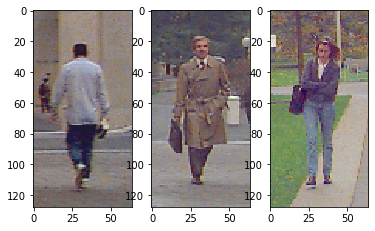

In [1]:
%matplotlib inline 
from skimage import io,color, transform
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import warnings
warnings.filterwarnings("ignore")

pers1 = io.imread('images/per00002.ppm')
pers2 = io.imread('images/per00007.ppm')
pers3 = io.imread('images/per00014.ppm')

fig = plt.figure()
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(pers1)
ax2.imshow(pers2)
ax3.imshow(pers3)


## Gradients and directions
First, implement the extraction of the gradient via convolution with the Sobel kernels. Translate the two result matrices into an image containing the gradient direction (one angle per pixel). Display this image for each of the three input images above. Like it fancy? Add transparency inversely proportional to the gradient magnitude (weak gradients are transparent). 

In [14]:
# dieser Code ist Teil eine Musterlösung, die von Adrian Defer zur Verfügung gestellt und von Tim renoviert wurde


def getGradientConv(image):
    Sx = np.array([
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1],
    ]) 
    Sy = Sx.T
    
    Gx = ndimage.convolve(image[:,:,0], Sx)
    Gy = ndimage.convolve(image[:,:,0], Sy)
    #magnitude
    G = np.sqrt(np.square(Gx) + np.square(Gy))
    #direction
    angles = np.degrees(np.arctan2(Gy, Gx))
    
    result = G
    
    return result

grad_pers1 = getGradientConv(pers1)
#grad_pers2 = getGradientConv(pers2)
#grad_pers3 = getGradientConv(pers3)

print(grad_pers1.dtype)
plt.imshow(grad_pers1)

"""
fig = plt.figure()
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(grad_pers1)
#ax2.imshow(grad_pers2)
#ax3.imshow(grad_pers3)"""

float16


'\nfig = plt.figure()\nax1 = plt.subplot(1, 3, 1)\nax2 = plt.subplot(1, 3, 2)\nax3 = plt.subplot(1, 3, 3)\nax1.imshow(grad_pers1)\n#ax2.imshow(grad_pers2)\n#ax3.imshow(grad_pers3)'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x17B0F078> (for post_execute):


ValueError: Unsupported dtype

ValueError: Unsupported dtype

<Figure size 432x288 with 1 Axes>

## Gradient orientation histograms (GOHs)
Now implement a function that generates GOHs on image cells. Pass a gradient direction image (as described above) to the function. The image cells should be 8 x 8 pixels in size. Please do not forget the voting with "bi-linear interpolation" (important!). Compute the GOH for the input image "star.png" with and without interpolation! Now rotate the image by -5° and compute both variants of the GOH again! What are the Euclidean differences of the histograms (original vs rotated) with and without interpolation?


In [3]:
star = io.imread('images/star.png')

# ndimage.rotate(star, -5, mode='nearest')

# ...

    

## Block and ROI normalization and creation of the HOG descriptor
* Given a fixed size ROI (128 x 64 pixels), create a descriptor as shown in the lecture (including normalization of the blocks and the total ROI). Please reuse the precalculated cell histograms for the blocks! 
* Calculate the descriptor for the three images above and for the unknown images "unknown1.png" and "unknown2.png". 
* Now compare the unknowns with the three person instances and calculate the Euclidean distance of the descriptors. Which picture has a smaller distance to the persons? (**RESULT**)